In [1]:
import itertools
import random
import operator
import datetime
import pickle
import igraph
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import *
from datetime import datetime, date, timedelta
from collections import defaultdict, Counter, OrderedDict
from tqdm import tqdm_notebook as tqdm
from itertools import compress
from scipy import stats

%matplotlib notebook

# Outbreak Detection in Brazilian Escort Network

In this notebook, we are presenting our outbreak detection approach and provide the code for the method as well as all code related to validation.

## 1. Load and explore dataset

We load the dataset about a Brazilian escort network. The data was scraped from an escort internet forum and was initially used here: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001109.

In [2]:
# import data
df = pd.read_csv('escort.CSV', sep=';', header=None, skiprows=24)

# set column names
df.columns = ['idf','idm','date','grade','an','or','mo']

# have a look at dataset
df.head()

,idf,idm,date,grade,an,or,mo
0,0,1,0,0,0,0,0
1,2,1,0,1,-1,1,-1
2,3,1,0,0,0,0,0
3,0,4,21,0,0,0,0
4,5,6,47,0,0,0,0


The meaning of the variables is as follows:
* *idf*: id for the female sex-sellers
* *idm*: id for the male sex-buyers
* *date*: date (day of posting)
* *grade*: female grade given by the male (Bad: -1, Neutral: 0, Good: +1)
* *an*: anal sex with/without condom? (Yes: +1, No: -1, Information not available: 0)
* *or*: oral sex with condom? (Yes: +1, No: -1, Information not available: 0)
* *mo*: mouth kiss? (Yes: +1, No: -1, Information not available: 0)

In [3]:
# how many edges?
print('Number of edges: {}'.format(len(df)))

# how many nodes?
print('Number of distinct male sex-buyers: {}'.format(df['idm'].nunique()))
print('Number of distinct female sex-sellers: {}'.format(df['idf'].nunique()))

Number of edges: 50632
Number of distinct male sex-buyers: 10106
Number of distinct female sex-sellers: 6624


In [4]:
# are id's of male and females unique?
sf = set(df['idf'])
sm = set(df['idm'])

sf.intersection(sm)

set()

The id's have no overlap and thus node id's are unique.

In [5]:
# min and max date
print('Starting date: {}'.format(np.min(df['date'])))
print('Ending date: {}'.format(np.max(df['date'])))

Starting date: 0
Ending date: 2232


The time is given with respect to the first day of the whole period, i.e. date 1000 is 1000 days after the first day of the observation period.

In [6]:
# How often are the most frequent sex-workers active?
df['idf'].value_counts().head()

18      615
4569    477
4200    449
98      433
3935    401
Name: idf, dtype: int64

In [7]:
# How often are the most frequent sex-buyers active?
df['idm'].value_counts().head()

3460    134
370     132
6558    128
924     115
2139    114
Name: idm, dtype: int64

------

## 2. Prepare data

We will only consider the last year of data, i.e. all edges between day 1'867 and 2'232.

In [8]:
# reduce dataset (only dates >= 1867)
df = df[df['date'] >= 1867]

In [9]:
# how many rows are left?
print('Number of edges in last year of data: {}'.format(len(df)))

# how many nodes?
print('Number of distinct male sex-buyers: {}'.format(df['idm'].nunique()))
print('Number of distinct female sex-sellers: {}'.format(df['idf'].nunique()))

Number of edges in last year of data: 15064
Number of distinct male sex-buyers: 4154
Number of distinct female sex-sellers: 2738


The last year of data contains 15'064 edges, 4'154 male sex-buyers, and 2'738 female sex-sellers. Next, we will transform the data into an edgelist of the form $(v_i, v_j, t)$.

In [10]:
# create a list with tuples that indicate the TVD of origin and arrival as well as the date
subset = df[['idf', 'idm', 'date']]
edgelist = [tuple(x) for x in subset.values]

# sort the list of movements by date
edgelist = sorted(edgelist, key = lambda x: x[2])

# how many edges?
print('Number of edges: {}'.format(len(edgelist)))

Number of edges: 15064


------

## 3. Define outbreak detection method

### 3.1 Load edgelist, find all nodes, and build adjacency dict

In [11]:
class OutbreakDetection(object):
    
    # initialize object
    def __init__(self, edgelist, date_monitoring, length_monitoring, is_directed=False):
        self.date_monitoring = date_monitoring
        self.length_monitoring = length_monitoring
        self.edgelist = [e for e in edgelist if e[2] >= (self.date_monitoring - self.length_monitoring) if e[2] <= self.date_monitoring]
        self.number_of_edges = len(self.edgelist)
        self.is_directed = is_directed
        
    # find all unique ids in monitoring period
    def find_nodes(self): 
        # get only nodes
        out = [[e[0], e[1]] for e in self.edgelist]
        # flatten list
        out = sorted(list(set([item for sublist in out for item in sublist])))
        # assign to attributes
        self.nodes = out
        self.number_of_nodes = len(out)
        
    # build multigraph
    def build_graph(self):
        # procedure for undirected
        if(self.is_directed==False):
            # get edge information in correct format
            edgeAttr = [(i[0], i[1], {'date':i[2]}) for i in self.edgelist]
            # create multigraph
            G = nx.MultiGraph()
            # add edges to graph
            G.add_edges_from(edgeAttr)
        else:
            raise NotImplementedError()
        return G
        
    # create adjacency dict
    def build_adjacency_dict(self):
        # empty dict
        adj = {}
        # procedure for undirected
        if(self.is_directed==False):
            # loop over nodes and add adjacent nodes to dict
            for n in self.nodes:
                edg1 = [(e[1], e[2]) for e in self.edgelist if e[0] == n]
                edg2 = [(e[0], e[2]) for e in self.edgelist if e[1] == n]
                adj[n] = edg1 + edg2
        else:
            raise NotImplementedError()
        # assign to attribute
        self.adjacency_dict = adj

### 3.2 Simulate spread

In [12]:
# function to simulate spread with temporal BFS
def bfs_temp(adjacency_dict, seed, date, p, recovery):
    # add seed-date pair to active list and to queue
    active, queue = [(seed, date)], [(seed, date)]
    # continue while queue contains elements
    while queue:
        # empty list for intermediate results
        temp = []
        # take first element in queue
        v = queue.pop(0)
        # add neighbors of v to temp if connection is within active period of v
        temp.extend([i for i in adjacency_dict[v[0]] if i[1] > v[1] if (i[1] - v[1]) <= recovery if i not in active])
        # random draw for all links in temp
        ind = np.random.uniform(0, 1, len(temp)) < p
        # find newly activated nodes based on random draw
        new_active = list(compress(temp, ind))
        # add newly activated nodes to active and queue
        active.extend(new_active)
        queue.extend(new_active) 
    return active

In [13]:
class OutbreakDetection(OutbreakDetection):
    
    # simulate spreading
    def simulate(self, p, recovery, nsim):
        # attributes
        self.p = p
        self.recovery = recovery
        self.nsim = nsim
        # cut-off date: only nodes that were activated later will still be active
        cutoff = self.date_monitoring - self.recovery
        # empty dict for results
        out = defaultdict(list)
        print('Simulation progress:')
        # loop over dates and seeds and simulate spread
        for d in tqdm(range(self.date_monitoring - self.length_monitoring, self.date_monitoring)):
            for seed in self.nodes:
                # empty list for temporary results
                sim_temp = []
                # simulation nsim times
                for i in range(self.nsim):
                    sim_temp.append(bfs_temp(self.adjacency_dict, seed, d, self.p, self.recovery))
                # keep only nodes that are still active at date of monitoring
                sim_temp = [[j[0] for j in i if j[1] >= cutoff] for i in sim_temp]
                # add simulation results to dict
                out[(seed, d)] = [list(set(l)) for l in sim_temp]
        # assign to attribute
        self.sim_list = out

### 3.3 Create inverted index

In [14]:
class OutbreakDetection(OutbreakDetection):
    
    # create inverted index
    def create_index(self):
        # create empty dict
        index = defaultdict(list)
        # get flat list of values
        sim_flat = [item for sublist in list(self.sim_list.values()) for item in sublist]
        # enumerate simulations and loop over them
        for i, nodes in enumerate(sim_flat):
            for n in nodes:
                index[n].append(i)
        # assign to attribute
        self.sim_ind = index
        
    # create inverted index by source (for source detection)
    def create_index_by_source(self):
        # create empty dict
        index = defaultdict(dict)
        # loop over sim_list
        for key, value in self.sim_list.items():
            # empty dict for temporary results
            temp = defaultdict(set)
            # enumerate simulations and loop over them
            for i, nodes in enumerate(value):
                for n in nodes:
                    temp[n].add(i)
            # add to dict
            index[key] = temp
        # assign to attribute
        self.sim_ind_source = index

### 3.4 Greedy maximization

In [15]:
class OutbreakDetection(OutbreakDetection):
    
    # function to compute detection likelihood
    def detection_probability(self, sensors):
        # empty list of sets
        sets = []
        # add all simulation runs that sensors see
        for s in sensors:
            sets.append(set(self.sim_ind[s]))
        # return the length of the union of the sets
        return len(set.union(*sets)) / (len(self.sim_ind.keys()) * self.length_monitoring * self.nsim)
    
    # function to greedily optimize
    def greedy_max(self, nsensors):
        # empty list of optimal observers
        optimal_observers = []
        # create a copy of nodelist
        node_list = self.nodes
        # dict for marginal gains
        marginal_gain = {}
        # iterate over all possible nodes and find marginal gain
        for node in node_list:
            marginal_gain[node] = self.detection_probability([node])
        # sort and get list of tuples
        marginal_gain = sorted(marginal_gain.items(), key=operator.itemgetter(1), reverse=True)
        # print first node to be chosen
        print('Optimal observers:')
        print('{} (marginal increase: {})'.format(marginal_gain[0][0], np.round(marginal_gain[0][1], 4)))
        # add top node to list of optimal observers
        optimal_observers.append(marginal_gain.pop(0)[0])
        # empty list to temporarily store activated nodes
        active = []
        # loop as long as we have not found enough sensors
        while len(optimal_observers) < nsensors:
            # get top node from list
            v = marginal_gain.pop(0)[0]
            # create a copy of optimal observers list
            obs = optimal_observers.copy()
            # add node in question to obs
            obs.append(v)
            # compute marginal gain
            marg = self.detection_probability(obs) - self.detection_probability(optimal_observers)
            # add newly computed marginal gain back to list
            marginal_gain.append((v, marg))
            # resort list
            marginal_gain = sorted(marginal_gain, key=lambda tup: tup[1], reverse=True)
            # if top node is still the same, then add to optimal set
            if marginal_gain[0][0] == v:
                # print chosen node
                print('{} (marginal increase: {})'.format(marginal_gain[0][0], np.round(marginal_gain[0][1], 4)))
                # add top node to list of optimal observers
                optimal_observers.append(marginal_gain.pop(0)[0])
                # clear active
                active.clear()
            else:
                if v not in active:
                    # if v is not activated yet, add it to list and continue loop
                    active.append(v)
                    continue
                else:
                    # if v is activated already, get all keys where value is maximal
                    max_val = marginal_gain[0][1]
                    max_keys = [i for i in marginal_gain if i[1] == max_val]
                    # randomly select a key from keys with max value
                    new = random.choice(max_keys)
                    # remove chosen key from marginal gains list
                    marginal_gain.remove(new)
                    # add node to optimal observers
                    optimal_observers.append(new[0])
                    # print chosen node
                    print('{} (marginal increase: {})'.format(new[0], np.round(new[1], 4)))
                    # clear active
                    active.clear()
        return optimal_observers

### 3.5 Source detection

In [16]:
class OutbreakDetection(OutbreakDetection):
    
    # function to find source likelihoods
    def detect_sources(self, evidence):
        # create empty dict
        out = {}
        # loop over index
        for key, value in self.sim_ind_source.items():
            # check if nodes in evidence are part of batch of simulations for source
            if set(evidence).issubset(set(value.keys())):
                # empty list of sets
                sets = []
                # find simulation numbers for nodes in evidence
                for s in evidence:
                    sets.append(set(value[s]))
                # compute number of simulations in common
                out[key] = len(set.intersection(*sets)) / self.nsim
            else:
                # if source does not contain evidence nodes, the overlap is 0
                out[key] = 0
        # normalize by total
        out = {k: v / total for total in (sum(out.values()),) for k, v in out.items()}
        # get only key-value pairs where value > 0
        out = {k: v for k, v in out.items() if v > 0}
        # turn them into list and remove dates
        out = [(k[0],v) for k,v in out.items()]
        # empty dict
        out_final = defaultdict(int)
        # add probabilities up over source nodes
        for k, v in out:
            out_final[k] += v
        # return sorted dictionary
        return OrderedDict(sorted(out_final.items(), key=lambda kv: kv[1], reverse=True))

------

## 4. Evaluate method

### 4.1 Baseline methods

In [17]:
class OutbreakDetection(OutbreakDetection):
    
    # function to compute degree of nodes
    def compute_degree(self, nsensors):
        # empty dict
        out = defaultdict(int)
        # loop over nodes and get degree from adjacency_dict
        for n in self.nodes:
            out[n] = len(set([i[0] for i in self.adjacency_dict[n]]))
        # sort by degree
        out = sorted(out.items(), key=lambda kv: kv[1], reverse=True)
        # return top degree nodes
        return out[0:nsensors]
    
    # function to find sentinel nodes
    def find_sentinels(self, nsensors, threshold=0.8, deterministic=True):
        # function to compute Jaccard similarity between any two nodes
        def jaccard_similarity(out, pair):
            x = out[pair[0]]
            y = out[pair[1]]
            inter_card = len(set.intersection(*[set(x), set(y)]))
            union_card = len(set.union(*[set(x), set(y)]))
            return inter_card/float(union_card)
        # empty dict for results
        out1 = defaultdict(set)
        # check if spread shall be deterministic:
        if deterministic:
            inf_p = 1
        else:
            inf_p = self.p
        # simulate the spreads from all source nodes
        for n in self.nodes:
            sim = bfs_temp(self.adjacency_dict, n, self.date_monitoring - self.length_monitoring, inf_p, self.recovery)
            out1[n] = set([j[0] for j in sim])
        # empty dict for results
        out2 = defaultdict(float)
        # compute Jaccard similarity between any two nodes
        for pair in itertools.combinations(self.nodes, r=2):
            out2[pair] = jaccard_similarity(out1, pair)
        # keep only pairs with similarity higher than threshold
        out2 = [k for k,v in out2.items() if float(v) >= threshold]
        # create graph and add nodes and edges
        G = nx.Graph()
        G.add_nodes_from(self.nodes)
        G.add_edges_from(out2)
        # find connected components in graph and sort them
        out3 = sorted(nx.connected_components(G), key=len, reverse=True)
        # empty dict for results
        clusters = defaultdict(int)
        # create clusters based on connected components
        for i, ids in enumerate(out3):
            for j in ids:
                clusters[j] = i
        # empty dict for results
        out4 = defaultdict(dict)
        # loop over simulations and count occurences per cluster
        for k,v in out1.items():
            c = clusters[k]
            for i in v:
                if not out4.get(i):
                    out4[i] = defaultdict(int)
                out4[i][c] += 1
        # empty dict for results
        out5 = defaultdict(tuple)
        # loop over k-v pairs in out4 and compute n and entropy
        for k,v in out4.items():
            n = np.sum(list(v.values()))
            probs = np.asarray(list(v.values())/n)
            log_probs = np.log(probs)
            if n == 1:
                entr = 0
            else:
                entr = -(1/np.log(n)) * np.sum(probs*log_probs)
            out5[k] = (n, entr)
        # sort by n
        out = sorted(out5.items(), key=lambda kv: kv[1][0], reverse=True)
        return out[0:nsensors]

### 4.2 Create evaluation data

In [18]:
class OutbreakDetection(OutbreakDetection):
    
    # function to compute degree of nodes
    def create_eval_data(self, eval_p, eval_recovery, eval_nsim, min_outbreak_size=0):
        # cut-off date: only nodes that were activated later will still be active
        cutoff = self.date_monitoring - eval_recovery
        # empty dict for results
        out = defaultdict(list)    
        # loop as long as the length of the output is not nsim
        while len(out) < eval_nsim:
            # randomly pick a seed node
            seed = random.choice(self.nodes)
            # randomly pick a starting date for the simulation
            seed_date = random.choice(list(range(self.date_monitoring - self.length_monitoring, self.date_monitoring)))
            # simulate from seed configuration
            sim = bfs_temp(self.adjacency_dict, seed, seed_date, eval_p, eval_recovery)
            # keep only nodes that are still active at monitoring date
            sim = [i for i in sim if i[1] >= cutoff]
            # if we set a min_outbreak_size, make sure given run satisfies condition
            # IMPORTANT: if recovery time is very short, simulations can run for a long time with min_outbreak_size > 0
            if len(sim) >= min_outbreak_size:
                out[(seed, seed_date)] = sim
        return out

### 4.3 Set parameters

In [19]:
# date of monitoring
# monitoring_date = 2232
monitoring_date = 2201

# length of monitoring window (days)
length_monitoring = 30

# number of simulations per seed configuration
nsim = 1000

# probability of infection in SIR process
p = 0.6

# length of recovery period (days)
recovery = 15

# determine the number of sensors
nsensors = 100

### 4.4 Run method

In [20]:
# create instance of outbreak detection
od = OutbreakDetection(edgelist, monitoring_date, length_monitoring)

od.find_nodes()
od.build_adjacency_dict()

In [21]:
od.simulate(p, recovery, nsim)
od.create_index()
od.create_index_by_source()

Simulation progress:


In [22]:
# find sensors
sensors_dtl = od.greedy_max(nsensors)
sensors_deg = od.compute_degree(nsensors)
sensors_sen = od.find_sentinels(nsensors)

Optimal observers:
4569 (marginal increase: 0.0045)
325 (marginal increase: 0.0044)
11780 (marginal increase: 0.0041)
561 (marginal increase: 0.0031)
16018 (marginal increase: 0.0031)
11717 (marginal increase: 0.003)
16196 (marginal increase: 0.0029)
11347 (marginal increase: 0.0029)
10388 (marginal increase: 0.0028)
13673 (marginal increase: 0.0028)
1566 (marginal increase: 0.0028)
16043 (marginal increase: 0.0025)
15999 (marginal increase: 0.0025)
14773 (marginal increase: 0.0025)
15605 (marginal increase: 0.0024)
3935 (marginal increase: 0.0023)
7632 (marginal increase: 0.0023)
16134 (marginal increase: 0.0023)
13305 (marginal increase: 0.002)
781 (marginal increase: 0.002)
14091 (marginal increase: 0.0019)
4585 (marginal increase: 0.0019)
16250 (marginal increase: 0.0018)
16027 (marginal increase: 0.0018)
7593 (marginal increase: 0.0018)
11309 (marginal increase: 0.0017)
1312 (marginal increase: 0.0017)
15161 (marginal increase: 0.0016)
15919 (marginal increase: 0.0016)
6214 (margi

In [23]:
# export
pickle.dump(sensors_dtl, open('C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/sensors_dtl.p', "wb"))
pickle.dump(sensors_deg, open('C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/sensors_deg.p', "wb"))
pickle.dump(sensors_sen, open('C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/sensors_sen.p', "wb"))

pickle.dump(od.sim_ind, open('C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/sim_ind.p', "wb"))
pickle.dump(od.sim_ind_source, open('C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/sim_ind_source.p', "wb"))

In [23]:
# import
# sensors_dtl = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_dtl.p", "rb"))
# sensors_deg = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_deg.p", "rb"))
# sensors_sen = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_sen.p", "rb"))

In [24]:
# get only nodes
sensors_deg_nodes = [i[0] for i in sensors_deg]
sensors_sen_nodes = [i[0] for i in sensors_sen]

# overlap between observers
print(len(set(sensors_dtl).intersection(sensors_deg_nodes)))
print(len(set(sensors_dtl).intersection(sensors_sen_nodes)))
print(len(set(sensors_deg_nodes).intersection(sensors_sen_nodes)))

51
22
35


### 4.5 Describe graph

In [25]:
# build graph
G = od.build_graph()

#### Some key numbers

In [26]:
print('Graph is directed: {}'.format(G.is_directed(), G.is_multigraph()))
print('Graph is multigraph: {}'.format(G.is_multigraph()))
print('Graph is connected: {}'.format(nx.is_connected(G)))
print('Graph is bipartite: {}'.format(nx.is_bipartite(G)))
print('Number of nodes: {}'.format(G.number_of_nodes()))
print('Number of edges: {}'.format(G.number_of_edges()))

Graph is directed: False
Graph is multigraph: True
Graph is connected: False
Graph is bipartite: True
Number of nodes: 1578
Number of edges: 1572


In [27]:
print('Number of nodes in class instance: {}'.format(od.number_of_nodes))
print('Number of edges in class instance: {}'.format(od.number_of_edges))

Number of nodes in class instance: 1578
Number of edges in class instance: 1572


In [28]:
# find all connected components
components = sorted(nx.connected_components(G), key=len, reverse=True)

print('Number of connected components: {}'.format(len(components)))
print('Size of largest connected component: {}'.format(len(components[0])))

Number of connected components: 226
Size of largest connected component: 691


In [29]:
# transform multigraph to simple graph
G_simple = nx.Graph(G)

# create dict with degrees
degree = dict(G_simple.degree())

print('Average degree: {}'.format(np.mean(list(degree.values()))))

Average degree: 1.8631178707224334


In [30]:
print('Density: {}'.format(nx.density(G_simple)))

Density: 0.001181431750616635


#### Graph plot

In [31]:
# create dict to map node ids to integers starting from 0
dict_map = dict([(y,x) for x,y in enumerate(sorted(set(od.nodes)))])

In [32]:
# build dictionary of male and female nodes
nodetypes_dict = {**dict((k,'f') for k in list(set(df['idf']))), **dict((k,'m') for k in list(set(df['idm'])))}
nodetypes_dict = {k: v for k,v in nodetypes_dict.items() if k in dict_map.keys()}
nodetypes_dict = {dict_map[k]: v for k,v in nodetypes_dict.items()}

In [33]:
# map sensor node ids to integers starting from 0
sensors_dtl_mapped = [dict_map[i] for i in sensors_dtl]
sensors_deg_nodes_mapped = [dict_map[i] for i in sensors_deg_nodes]

In [34]:
# generate graph
g = igraph.Graph(od.number_of_nodes, directed=False)

# (static) edge list
edges = list(set([(dict_map[e[0]], dict_map[e[1]]) for e in od.edgelist]))

# add edges from edge list
g.add_edges(edges)

# list of node types (sex-buyers or sex-sellers)
nodetypes = [nodetypes_dict[v.index] for v in g.vs]

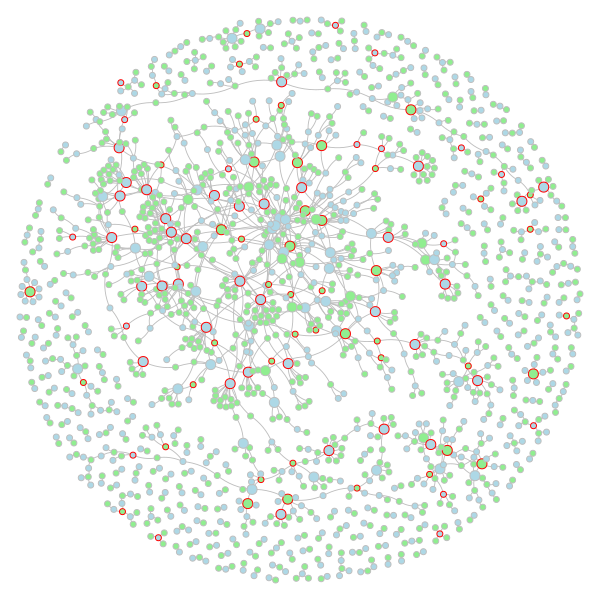

In [37]:
# set style
visual_style = {}
visual_style["layout"] = g.layout_fruchterman_reingold()
visual_style["vertex_color"] = ['lightgreen' if i == 'm' else 'lightblue' for i in nodetypes]
visual_style["vertex_frame_color"] = ['red' if v.index in sensors_dtl_mapped else 'grey' for v in g.vs]
visual_style["vertex_size"] = [10 if v.index in sensors_deg_nodes_mapped else 6 for v in g.vs]
visual_style["edge_curved"] = 0.2
visual_style["edge_width"] = 0.9
visual_style["edge_color"] = 'grey'

# visualize graph
igraph.plot(g, "graph.pdf", **visual_style)

### 4.6 Results outbreak detection

#### Import sensors (optional)

In [28]:
# import observers from files
sensors_dtl = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_dtl.p", "rb"))
sensors_deg = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_deg.p", "rb"))
sensors_sen = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_sen.p", "rb"))

In [29]:
# get only nodes
sensors_deg_nodes = [i[0] for i in sensors_deg]
sensors_sen_nodes = [i[0] for i in sensors_sen]

#### Create evaluation data

In [38]:
# parameters for evaluation
eval_p = 0.6
eval_recovery = 15
eval_nsim = 10000
min_outbreak_size = 0

# create evaluation data
eval_data = od.create_eval_data(eval_p, eval_recovery, eval_nsim, min_outbreak_size)

#### Compute fraction of detected outbreaks

In [39]:
# initialize empty lists for results
eval_prob_list = []
eval_degr_list = []
eval_sent_list = []
eval_rand_list = []

# get activated nodes for all simulation runs
eval_data_values = list(eval_data.values())

# initialize empty list for random observers
random_sample = []

# loop over observer set sizes
for ns in range(0, 105, 5):
    
    # initialize counters
    eval_prob = 0
    eval_degr = 0
    eval_sent = 0
    eval_rand = 0
    
    # increment the random sample set
    random_sample.extend(random.sample(od.nodes, ns - len(random_sample)))
    
    # loop over simulation runs
    for i in range(len(eval_data_values)):
        
        # get only nodes
        active_nodes = [n[0] for n in eval_data_values[i]]
        
        # find number of detected outbreaks
        if not set(active_nodes).isdisjoint(sensors_dtl[0:ns]):
            eval_prob += 1
        if not set(active_nodes).isdisjoint(sensors_deg_nodes[0:ns]):
            eval_degr += 1
        if not set(active_nodes).isdisjoint(sensors_sen_nodes[0:ns]):
            eval_sent += 1
        if not set(active_nodes).isdisjoint(random_sample):
            eval_rand += 1
            
    # append results to lists
    eval_prob_list.append(eval_prob / len(eval_data_values))
    eval_degr_list.append(eval_degr / len(eval_data_values))
    eval_sent_list.append(eval_sent / len(eval_data_values))
    eval_rand_list.append(eval_rand / len(eval_data_values))

#### Compute expected detection likelihood

In [40]:
# initialize list with 0 for empty observer set
eval_expected_prob = [0]

# loop over observer set sizes and compute expected detection probability
for ns in range(5, 105, 5):
    eval_expected_prob.append(od.detection_probability(sensors_dtl[0:ns]))

#### Plot results

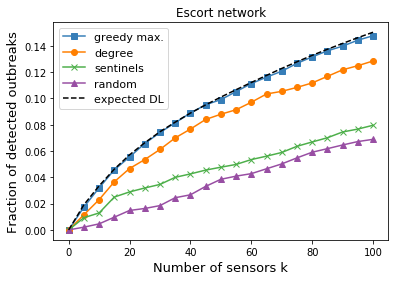

In [43]:
# values for x-axis
x = list(range(0, 105, 5))

# values for y-axis
y1 = eval_prob_list
y2 = eval_degr_list
y3 = eval_sent_list
y4 = eval_rand_list
y5 = eval_expected_prob

# plotting lines
plt.plot(x, y1, marker = 's', c = '#377eb8', label = "greedy max.")
plt.plot(x, y2, marker = 'o', c = '#ff7f00', label = "degree")
plt.plot(x, y3, marker = 'x', c = '#4daf4a', label = "sentinels")
plt.plot(x, y4, marker = '^', c = '#984ea3', label = "random")
plt.plot(x, y5, ls = 'dashed', c = 'black', label = "expected DL")

# plot axis labels
plt.xlabel('Number of sensors k', size = 13)
plt.ylabel('Fraction of detected outbreaks', size = 13)

# define x-ticks
# plt.xticks(np.arange(0, 120, 20))
# plt.yticks(np.arange(0, 0.10, 0.01))

# set title
plt.title('Escort network')

# plot legend
plt.legend(prop={'size': 11})

# save plot
# plt.savefig("eval.eps", format = 'eps', dbi = 300,  bbox_inches='tight');
plt.savefig("eval.pdf", format = 'pdf', dbi = 300,  bbox_inches='tight');

#### Plot results for different outbreak sizes

In [44]:
# parameters for evaluation
eval_p = 0.6
eval_recovery = 15
eval_nsim = 3000
nsensors = 10

# initialize empty lists for results
eval_prob_list = []
eval_degr_list = []
eval_sent_list = []
eval_rand_list = []

# initialize empty list for random observers
random_sample = []

# get random node sample
random_sample.extend(random.sample(od.nodes, nsensors))

# loop over minimal outbreak sizes
for min_outbreak_size in range(0, 6, 1):
    
    # simulate outbreaks
    sim_runs = od.create_eval_data(eval_p, eval_recovery, eval_nsim, min_outbreak_size)
    
    # get activated nodes for all simulation runs
    sim_runs_values = list(sim_runs.values())

    # initialize counters
    eval_prob = 0
    eval_degr = 0
    eval_sent = 0
    eval_rand = 0
    
    # loop over simulation runs
    for i in range(len(sim_runs_values)):
        
        # get only nodes
        active_nodes = [n[0] for n in sim_runs_values[i]]
        
        # find number of detected outbreaks
        if not set(active_nodes).isdisjoint(sensors_dtl[0:nsensors]):
            eval_prob += 1
        if not set(active_nodes).isdisjoint(sensors_deg_nodes[0:nsensors]):
            eval_degr += 1
        if not set(active_nodes).isdisjoint(sensors_sen_nodes[0:nsensors]):
            eval_sent += 1
        if not set(active_nodes).isdisjoint(random_sample):
            eval_rand += 1
            
    # append results to lists
    eval_prob_list.append(eval_prob / len(sim_runs_values))
    eval_degr_list.append(eval_degr / len(sim_runs_values))
    eval_sent_list.append(eval_sent / len(sim_runs_values))
    eval_rand_list.append(eval_rand / len(sim_runs_values))

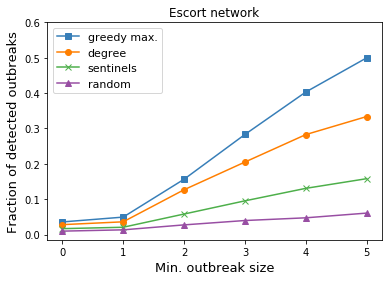

In [46]:
# values for x-axis
x = list(range(0, 6, 1))

# values for y-axis
y1 = eval_prob_list
y2 = eval_degr_list
y3 = eval_sent_list
y4 = eval_rand_list

# plotting lines
plt.plot(x, y1, marker = 's', c = '#377eb8', label = "greedy max.")
plt.plot(x, y2, marker = 'o', c = '#ff7f00', label = "degree")
plt.plot(x, y3, marker = 'x', c = '#4daf4a', label = "sentinels")
plt.plot(x, y4, marker = '^', c = '#984ea3', label = "random")

# plot axis labels
plt.xlabel('Min. outbreak size', size = 13)
plt.ylabel('Fraction of detected outbreaks', size = 13)

# define x-ticks
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 0.7, 0.1))

# set title
plt.title('Escort network')

# plot legend
plt.legend(prop={'size': 11})

# save plot
# plt.savefig("eval.eps", format = 'eps', dbi = 300, bbox_inches='tight');
plt.savefig("eval.pdf", format = 'pdf', dbi = 300,  bbox_inches='tight');

#### Plot result if we assume the wrong parametrization for $p$

In [47]:
# import observers from files
sensors_dtl_01 = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p01_rec15/sensors_dtl.p", "rb"))
sensors_dtl_03 = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p03_rec15/sensors_dtl.p", "rb"))
sensors_dtl_06 = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_dtl.p", "rb"))
sensors_dtl_09 = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p09_rec15/sensors_dtl.p", "rb"))

In [48]:
# overlap between observers
print(len(set(sensors_dtl_06[0:20]).intersection(sensors_dtl_01[0:20])))
print(len(set(sensors_dtl_06[0:20]).intersection(sensors_dtl_03[0:20])))
print(len(set(sensors_dtl_06[0:20]).intersection(sensors_dtl_09[0:20])))

13
15
15


This implies that different parametrizations for $p$ result in similar observer sets. The 20 first observers in the observer set for $p=0.6$ have a $65-75\%$ overlap with the other observer sets.

In [49]:
# parameters for evaluation
eval_p = 0.6
eval_recovery = 15
eval_nsim = 10000
min_outbreak_size = 0

# create evaluation data
eval_data = od.create_eval_data(eval_p, eval_recovery, eval_nsim, min_outbreak_size)

In [50]:
# initialize empty lists for results
eval_prob_list_01 = []
eval_prob_list_03 = []
eval_prob_list_06 = []
eval_prob_list_09 = []

# get activated nodes for all simulation runs
eval_data_values = list(eval_data.values())

# loop over observer set sizes
for ns in range(0, 105, 5):
    
    # initialize counters
    eval_prob_01 = 0
    eval_prob_03 = 0
    eval_prob_06 = 0
    eval_prob_09 = 0
    
    # loop over simulation runs
    for i in range(len(eval_data_values)):
        
        # get only nodes
        active_nodes = [n[0] for n in eval_data_values[i]]
        
        # find number of detected outbreaks
        if not set(active_nodes).isdisjoint(sensors_dtl_01[0:ns]):
            eval_prob_01 += 1
        if not set(active_nodes).isdisjoint(sensors_dtl_03[0:ns]):
            eval_prob_03 += 1
        if not set(active_nodes).isdisjoint(sensors_dtl_06[0:ns]):
            eval_prob_06 += 1
        if not set(active_nodes).isdisjoint(sensors_dtl_09[0:ns]):
            eval_prob_09 += 1
            
    # append results to lists
    eval_prob_list_01.append(eval_prob_01 / len(eval_data_values))
    eval_prob_list_03.append(eval_prob_03 / len(eval_data_values))
    eval_prob_list_06.append(eval_prob_06 / len(eval_data_values))
    eval_prob_list_09.append(eval_prob_09 / len(eval_data_values))

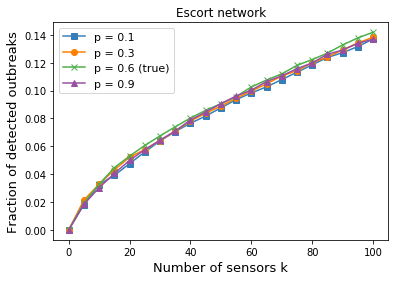

In [52]:
# values for x-axis
x = list(range(0, 105, 5))

# values for y-axis
y1 = eval_prob_list_01
y2 = eval_prob_list_03
y3 = eval_prob_list_06
y4 = eval_prob_list_09

# plotting lines
plt.plot(x, y1, marker = 's', c = '#377eb8', label = "p = 0.1")
plt.plot(x, y2, marker = 'o', c = '#ff7f00', label = "p = 0.3")
plt.plot(x, y3, marker = 'x', c = '#4daf4a', label = "p = 0.6 (true)")
plt.plot(x, y4, marker = '^', c = '#984ea3', label = "p = 0.9")

# plot axis labels
plt.xlabel('Number of sensors k', size = 13)
plt.ylabel('Fraction of detected outbreaks', size = 13)

# define x-ticks
# plt.xticks(np.arange(0, 120, 20))
# plt.yticks(np.arange(0, 0.10, 0.01))

# set title
plt.title('Escort network')

# plot legend
plt.legend(prop={'size': 11})

# save plot
plt.savefig("eval.eps", format = 'eps', dbi = 300, bbox_inches='tight');

#### Plot result if we assume the wrong parametrization for $\mu^{-1}$

In [53]:
# import observers from files
sensors_dtl_5 = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec05/sensors_dtl.p", "rb"))
sensors_dtl_15 = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec15/sensors_dtl.p", "rb"))
sensors_dtl_30 = pickle.load(open("C:/Users/martin.sterchi/Desktop/outbreak_simulations/escort-network/p06_rec30/sensors_dtl.p", "rb"))

In [54]:
# parameters for evaluation
eval_p = 0.6
eval_recovery = 15
eval_nsim = 10000
min_outbreak_size = 0

# create evaluation data
eval_data = od.create_eval_data(eval_p, eval_recovery, eval_nsim, min_outbreak_size)

In [57]:
# initialize empty lists for results
eval_prob_list_5 = []
eval_prob_list_15 = []
eval_prob_list_30 = []

# get activated nodes for all simulation runs
eval_data_values = list(eval_data.values())

# loop over observer set sizes
for ns in range(0, 105, 5):
    
    # initialize counters
    eval_prob_5 = 0
    eval_prob_15 = 0
    eval_prob_30 = 0
    
    # loop over simulation runs
    for i in range(len(eval_data_values)):
        
        # get only nodes
        active_nodes = [n[0] for n in eval_data_values[i]]
        
        # find number of detected outbreaks
        if not set(active_nodes).isdisjoint(sensors_dtl_5[0:ns]):
            eval_prob_5 += 1
        if not set(active_nodes).isdisjoint(sensors_dtl_15[0:ns]):
            eval_prob_15 += 1
        if not set(active_nodes).isdisjoint(sensors_dtl_30[0:ns]):
            eval_prob_30 += 1
            
    # append results to lists
    eval_prob_list_5.append(eval_prob_5 / len(eval_data_values))
    eval_prob_list_15.append(eval_prob_15 / len(eval_data_values))
    eval_prob_list_30.append(eval_prob_30 / len(eval_data_values))

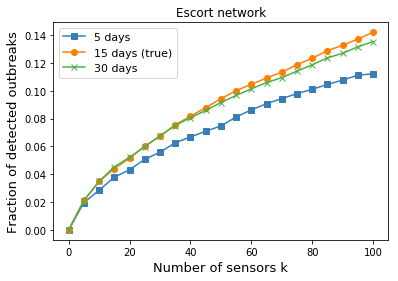

In [59]:
# values for x-axis
x = list(range(0, 105, 5))

# values for y-axis
y1 = eval_prob_list_5
y2 = eval_prob_list_15
y3 = eval_prob_list_30

# plotting lines
plt.plot(x, y1, marker = 's', c = '#377eb8', label = "5 days")
plt.plot(x, y2, marker = 'o', c = '#ff7f00', label = "15 days (true)")
plt.plot(x, y3, marker = 'x', c = '#4daf4a', label = "30 days")

# plot axis labels
plt.xlabel('Number of sensors k', size = 13)
plt.ylabel('Fraction of detected outbreaks', size = 13)

# define x-ticks
# plt.xticks(np.arange(0, 120, 20))
# plt.yticks(np.arange(0, 0.10, 0.01))

# set title
plt.title('Escort network')

# plot legend
plt.legend(prop={'size': 11})

# save plot
plt.savefig("eval.eps", format = 'eps', dbi = 300, bbox_inches='tight');

### 4.7 Results source detection

#### Create evaluation data

In [47]:
# parameters for evaluation
eval_p = 0.6
eval_recovery = 15
eval_nsim = 1000
min_outbreak_size = 8

# create evaluation data (min_outbreak_size should not be larger than 3)
eval_data = od.create_eval_data(eval_p, eval_recovery, eval_nsim, min_outbreak_size)

In [48]:
# empty lists for results
res_detection1 = []
res_detection2 = []
res_detection3 = []

# loop over simulations
for k,v in eval_data.items():
    
    # source is first element of key
    source = k[0]
    
    # get only nodes
    active_nodes = list(set([n[0] for n in v]))
    
    # randomly sample 1,2,3 nodes from set of active nodes
    evidence1 = random.sample(active_nodes, 1)
    evidence2 = random.sample(active_nodes, 2)
    evidence3 = random.sample(active_nodes, 3)
    
    # compute source detection
    source_det1 = list(od.detect_sources(evidence1))
    source_det2 = list(od.detect_sources(evidence2))
    source_det3 = list(od.detect_sources(evidence3))

    # add results to lists
    res_detection1.append((evidence1, source_det1.index(source)))
    res_detection2.append((evidence2, source_det2.index(source)))
    res_detection3.append((evidence3, source_det3.index(source)))

In [49]:
# function to summarize values into dict
def to_dict(outlist, nsim):
    # empty dict
    out = {}
    # summarize all ranks larger 4 into one category
    temp = [i[1] if i[1] <= 4 else '> 5' for i in outlist]
    # count elements for all categories
    for i in set(temp):
        out[i] = temp.count(i) / nsim
    return out

In [50]:
rs1 = to_dict(res_detection1, eval_nsim)
rs2 = to_dict(res_detection2, eval_nsim)
rs3 = to_dict(res_detection3, eval_nsim)

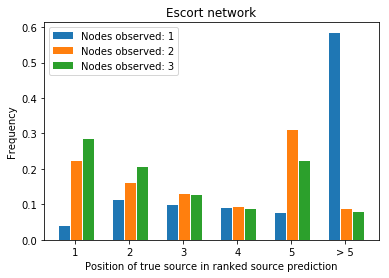

In [52]:
# initialize plot
fig, ax = plt.subplots()

# location for groups on x-axis
ind = np.arange(6)

# bar width
width = 0.2

# plot bars
p1 = ax.bar(ind, rs1.values(), width)
p2 = ax.bar(ind + 1.1*width, rs2.values(), width)
p3 = ax.bar(ind + 2.2 * width, rs3.values(), width)

# set xticks and xtick labels
ax.set_xticks(ind + 2 * width / 2)
ax.set_xticklabels(('1', '2', '3', '4', '5', '> 5'))

# legend
ax.legend((p1[0], p2[0], p3[0]), ('Nodes observed: 1', 'Nodes observed: 2', 'Nodes observed: 3'))
ax.autoscale_view()

# axis labels
ax.set_xlabel('Position of true source in ranked source prediction')
ax.set_ylabel('Frequency')

ax.set_title('Escort network')

# save plot
# plt.savefig("source_eval.eps", format = 'eps', dbi = 300, bbox_inches='tight');
plt.savefig("source_eval.pdf", format = 'pdf', dbi = 300, bbox_inches='tight');